# Python: Difference-in-Differences Pre-Testing

This example illustrates how to use the Difference-in-Differences implmentation `DoubleMLDID` of the [DoubleML](https://docs.doubleml.org/stable/index.html) package can be used to pre-test the parallel trends assumptions.
The example is based on the great implmentation of the [did-package](https://cran.r-project.org/web/packages/did/vignettes/did-basics.html) in `R`. 
You can find further references and a detailed guide on pre-testing with the `did`-package at the [did-package pre-testing documentation](https://cran.r-project.org/web/packages/did/vignettes/pre-testing.html).

In [1]:
import numpy as np
import pandas as pd
from doubleml import DoubleMLData, DoubleMLDID
from lightgbm import LGBMClassifier, LGBMRegressor

At first, we will generate some data to evaluate the corresponding effect estimates. The DGP is slightly adjusted from [did-package pre-testing documentation](https://cran.r-project.org/web/packages/did/vignettes/pre-testing.html) to consider conditional non-linear parallel trends.

We will consider $n_{obs}=1000$ units for $2n_t$ time periods $t\in\{-n_t, .., n_t - 1\}$, where the treatment is applied just before $t=0$.
The data generating process will take the following form

$$
Y_{it} = \theta_t + \eta_i + D_{i}\mu_{it} + g(X_{it}) + \epsilon_{it}.
$$
Here $\theta_t = t$ denotes a time fixed effect, $\eta_i\sim \mathcal{N}(0,1)$ is a unit fixed effect, $X_{it}\sim\mathcal{N}(0, I_4)\in \mathbb{R}^4$ denote 'pre-treatment' covariates for the time period $t$ and $\epsilon_{it}\sim \mathcal{N}(0,1)$ are independent error terms.
Further, $\mu_{it} \sim \mathcal{N}(\tau,1)$ denote time varying individual effects with $\tau = (\underbrace{0,\dots,0}_{n_t\ times}, n_t, \dots, 1)^T$ beeing the average effects (coinciding with the ATTE since $\mu_{it}$ is independent of $X$.) The treatment indicator $D_{i}$ denotes whether unit $i$ was treated between $t=-1$ and $t=0$ and is generated as

$$
\begin{align*}
f_{ps}(X) &= 0.75\cdot(-X_1 + 0.5X_2 - 0.25X_3 - 0.1X_4X_3 + \cos(5X_2))\\
D_{i} &= \frac{\exp(f_{ps}(X_{i0}))}{1+\exp(f_{ps}(X_{i0}))}
\end{align*}
$$

Finally, the direct effect of the covariates is given via

$$
g(X) = \exp(X_2) - \sin(5X_3) + 2X_4.
$$


In [2]:
np.random.seed(42)
n_obs = 1000
n_time_periods = 5

time_periods = (np.arange(2*n_time_periods) - n_time_periods)

# fixed effects
theta = np.zeros(shape=(n_obs, 2*n_time_periods)) + time_periods 
eta = np.random.normal(loc=0, scale=1, size=(n_obs,1))

# covariates
X = np.random.normal(loc=0, scale=1, size=(n_obs, 4, 2*n_time_periods))

# treatment effects
mu_means = np.concatenate((np.zeros(n_time_periods) , np.arange(n_time_periods, 0, -1)))
mu = np.random.normal(loc=0, scale=1, size=(n_obs, 2*n_time_periods)) + mu_means

# treatment
f_ps = 0.75*(-X[:, 0, 0] + 0.5*X[:, 1, 0] - 0.25*X[:, 2, 0] - 0.1*X[:, 3, 0]*X[:, 2, 0] + np.cos(5*X[:, 1, 0]))
ps = (np.exp(f_ps) / (1 + np.exp(f_ps))).reshape(-1,1)
u = np.random.uniform(low=0, high=1, size=(n_obs,1))
treatment = np.ones(shape=(n_obs, 2*n_time_periods)) * (ps >= u)


# outcome
g_X = (np.exp(X[:, 1, :]) - np.sin(5*X[:, 2, :]) + 2*X[:, 3, :])
epsilon = np.random.normal(loc=0, scale=1, size=(n_obs, 2*n_time_periods))
Y = theta + eta + treatment*mu + g_X + epsilon

Generate a corresponding dataframe

In [3]:
# generate dataframe
Y_df = np.hstack(Y)
treatment_df = np.hstack(treatment)
X_df = np.transpose(np.hstack(X))
time_df = np.hstack(np.ones(shape=(n_obs, 2*n_time_periods))*time_periods)
individual_df = np.hstack(np.ones(shape=(n_obs, 2*n_time_periods))*np.arange(n_obs).reshape(-1,1))

data = pd.DataFrame(np.column_stack((Y_df,treatment_df, X_df, time_df, individual_df)),
                    columns = ['y'] + ['d'] + [f'X_{i}' for i in range(4)] + ['t'] + ['i'])
print(data)

              y    d       X_0       X_1       X_2       X_3    t      i
0     -2.354188  1.0  1.399355  1.317394  0.522835 -0.257377 -5.0    0.0
1     -5.045624  1.0  0.924634  0.197600 -0.573700 -1.668584 -4.0    0.0
2      5.014432  1.0  0.059630  2.075261 -0.024355  0.399223 -3.0    0.0
3     -0.002290  1.0 -0.646937 -0.689188  2.142270  0.647196 -2.0    0.0
4      4.024926  1.0  0.698223  1.735964  1.727543 -0.483186 -1.0    0.0
...         ...  ...       ...       ...       ...       ...  ...    ...
9995   6.412477  1.0  1.152926 -0.405203 -0.654755  0.590320  0.0  999.0
9996   9.881465  1.0 -0.410681  0.698244 -0.132454  0.760915  1.0  999.0
9997   1.591080  1.0 -1.082804 -0.533489 -0.344834 -1.482790  2.0  999.0
9998  13.709026  1.0  0.619454  1.666307  0.304201  1.264086  3.0  999.0
9999   7.230956  1.0  0.336612  1.687854 -1.245720 -0.644799  4.0  999.0

[10000 rows x 8 columns]


We will just rely on [LightGBM](https://lightgbm.readthedocs.io/en/latest/index.html) with a small number of trees.

In [4]:
n_estimators = 50
ml_g = LGBMRegressor(n_estimators=n_estimators, num_leaves=5, verbose=-1)
ml_m = LGBMClassifier(n_estimators=n_estimators, num_leaves=5, verbose=-1)

Finally, construct the corresponding `DoubleMLData` for each time period and fit a `DoubleMLDID` model.
Remark thatwe have to include the covariates from both time periods (and they are either pre-treatment or independent of previous outcomes).

In [5]:
df = pd.DataFrame(np.nan, 
                  index=range(2*n_time_periods-1), 
                  columns=['lower', 'effect', 'upper'])
df['time'] = time_periods[1:]
df['true_effect'] = mu_means[1:]

np.random.seed(42)
for t_idx, t in enumerate(time_periods[1:]):
    if t <= 0:
        t_diff = t-1
    else:
        # compare to outcome before treatment
        t_diff = -1
    # outcome as the difference for each model
    y_diff = data[data['t'] == t]['y'].values - data[data['t'] == t_diff]['y'].values
    covariates = np.column_stack((data[data['t'] == t][[f'X_{i}' for i in range(4)]].values, data[data['t'] == t_diff][[f'X_{i}' for i in range(4)]].values))
    dml_data = DoubleMLData.from_arrays(x=covariates,
                                        y=y_diff,
                                        d=data[data['t'] == t]['d'].values)
    dml_did = DoubleMLDID(dml_data,
                          ml_g=ml_g,
                          ml_m=ml_m)
    dml_did.fit()

    df.at[t_idx, 'effect'] = dml_did.coef
    confint = dml_did.confint(level=0.95)
    df.at[t_idx, 'lower'] = confint['2.5 %'].iloc[0]
    df.at[t_idx, 'upper'] = confint['97.5 %'].iloc[0]

Take a look at the results

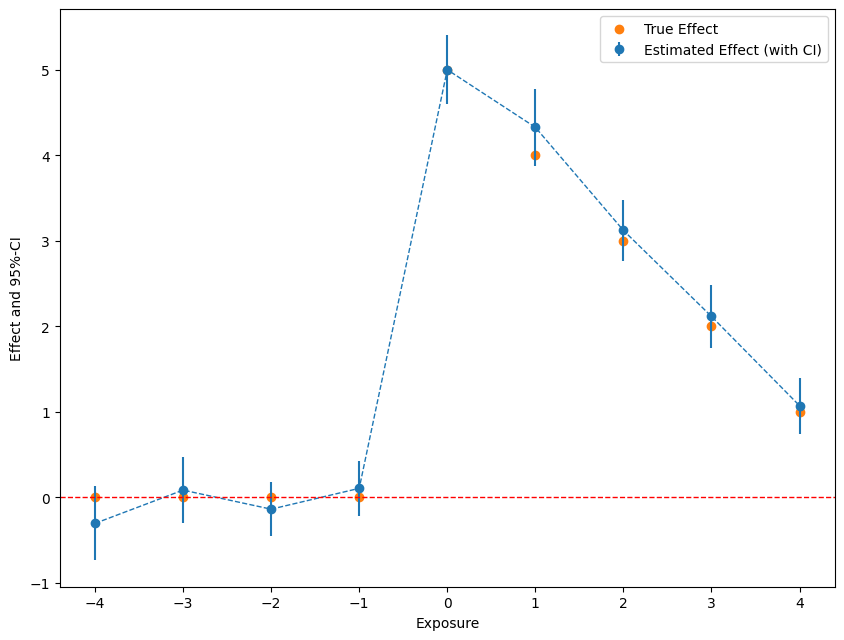

In [6]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 10., 7.5
fig, ax = plt.subplots()

errors = np.full((2, 2*n_time_periods - 1), np.nan)
errors[0, :] = df['effect'] -   df['lower']
errors[1, :] = df['upper'] - df['effect']

plt.errorbar(df['time'], df['effect'], fmt='o', yerr=errors, color='#1F77B4',
             ecolor='#1F77B4', label='Estimated Effect (with CI)')
ax.plot(time_periods[1:], df['effect'], linestyle='--', color='#1F77B4', linewidth=1)

# add horizontal line
ax.axhline(y=0, color='r', linestyle='--', linewidth=1)

# add true effect
ax.scatter(x=df['time'], y=df['true_effect'], c='#FF7F0E', label='True Effect')

plt.xlabel('Exposure')
plt.legend()
_ = plt.ylabel('Effect and 95%-CI')